In [ ]:
#@title 1. Импорт библиотек и данных

from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns; sns.set()


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import cross_validate

from sklearn import preprocessing

In [ ]:
# uploaded = files.upload()

# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions download -c urfu-engai-ml-2022-classification

# !unzip urfu-engai-ml-2022-classification.zip

In [ ]:
DF_train = pd.read_csv('/content/Train.csv', delimiter = ',', index_col = 0) #данные для обучения
DF_test = pd.read_csv('/content/Test.csv', delimiter = ',', index_col = 0) #данные для теста
Target = pd.read_csv('/content/Target.csv', delimiter = ',', index_col = 0) #целевые значения
Submission = pd.read_csv('/content/Submission.csv', delimiter = ',', index_col = 0) #форма для получившегося результата

DF_train

,code,year,period,id,Country,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling
11,EEA_3161-03-3,2009,2009-04--2009-10,FRGR0220,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
20,EEA_3161-05-5,2009,2009-01--2009-12,FRDR179,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
27,EEA_3161-01-1,2009,2009-01--2009-12,FRDR174,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
28,EEA_3161-05-5,2009,2009-01--2009-12,FRDR174,France,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
33,EEA_3161-03-3,2009,2009-01--2009-12,FRGR0173,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19889,EEA_31615-01-7,2009,2009-01--2009-12,FRFR2,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
19893,EEA_3161-03-3,2009,2009-01--2009-12,ES080MSPF01-03,Spain,50941692.0,0.0,87.158924,49.0,8.0,3.0,14.0,15.0,9.0,0.0,0.0,16.84
19894,EEA_3161-01-1,2009,2009-01--2009-12,ES080MSPF18-28,Spain,50941692.0,0.0,87.158924,49.0,8.0,3.0,14.0,15.0,9.0,0.0,0.0,16.84
19900,EEA_3161-03-3,2009,2008-12--2009-02,FRHR251A,France,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26


In [ ]:
#@title 2. Анализ данных

DF_train_index = DF_train.index
DF_test_index = DF_test.index

DF_combined = pd.concat([DF_train, DF_test]) #объединим тестовые и тренировочные данные для анализа и применения изменений
DF_combined = DF_combined.astype({'year': 'object'}) #Изменим тип данных для колонки year

DF_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3660 entries, 11 to 19915
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             3660 non-null   object 
 1   year             3660 non-null   object 
 2   period           3660 non-null   object 
 3   id               3660 non-null   object 
 4   Country          3660 non-null   object 
 5   tourists         3660 non-null   float64
 6   venue            3660 non-null   float64
 7   rate             3660 non-null   float64
 8   food             3660 non-null   float64
 9   glass            3660 non-null   float64
 10  metal            3660 non-null   float64
 11  other            3660 non-null   float64
 12  paper            3660 non-null   float64
 13  plastic          3660 non-null   float64
 14  leather          3660 non-null   float64
 15  green_waste      3660 non-null   float64
 16  waste_recycling  3660 non-null   float64
dtypes: float64(1

In [ ]:
cat_columns = [] #определим категориальные и числовые данные
num_columns = []

for column_name in DF_combined.columns:
    if (DF_combined[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))
print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['code', 'year', 'period', 'id', 'Country'] 
 Число столблцов =  5
Числовые данные:	  ['tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
 Число столблцов =  12


In [ ]:
DF_combined.describe() #оценим числовые характеристики данных

,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling
count,3.660000e+03,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000
mean,5.569954e+07,0.090984,11.070253,31.853109,8.529104,3.086691,24.146068,19.697694,10.506295,0.094820,0.833948,23.062085
std,2.304268e+07,0.561277,28.400648,8.886749,2.974285,0.883262,6.262395,4.261491,4.215245,0.582198,2.556819,4.803606
min,5.300380e+05,0.000000,0.000000,14.180000,2.200000,1.380000,0.000000,6.100000,1.450000,0.000000,0.000000,0.760000
25%,5.094169e+07,0.000000,0.000000,32.000000,8.000000,3.000000,26.000000,18.900000,9.000000,0.000000,0.000000,22.260000
50%,7.117635e+07,0.000000,0.000000,32.000000,10.000000,3.000000,26.000000,20.000000,9.000000,0.000000,0.000000,22.260000
75%,7.117635e+07,0.000000,0.000000,32.000000,10.000000,3.000000,26.000000,20.000000,9.000000,0.000000,0.000000,22.260000
max,7.117635e+07,7.000000,87.158924,62.300000,21.400000,9.200000,44.050000,37.830000,22.900000,4.000000,19.180000,47.830000


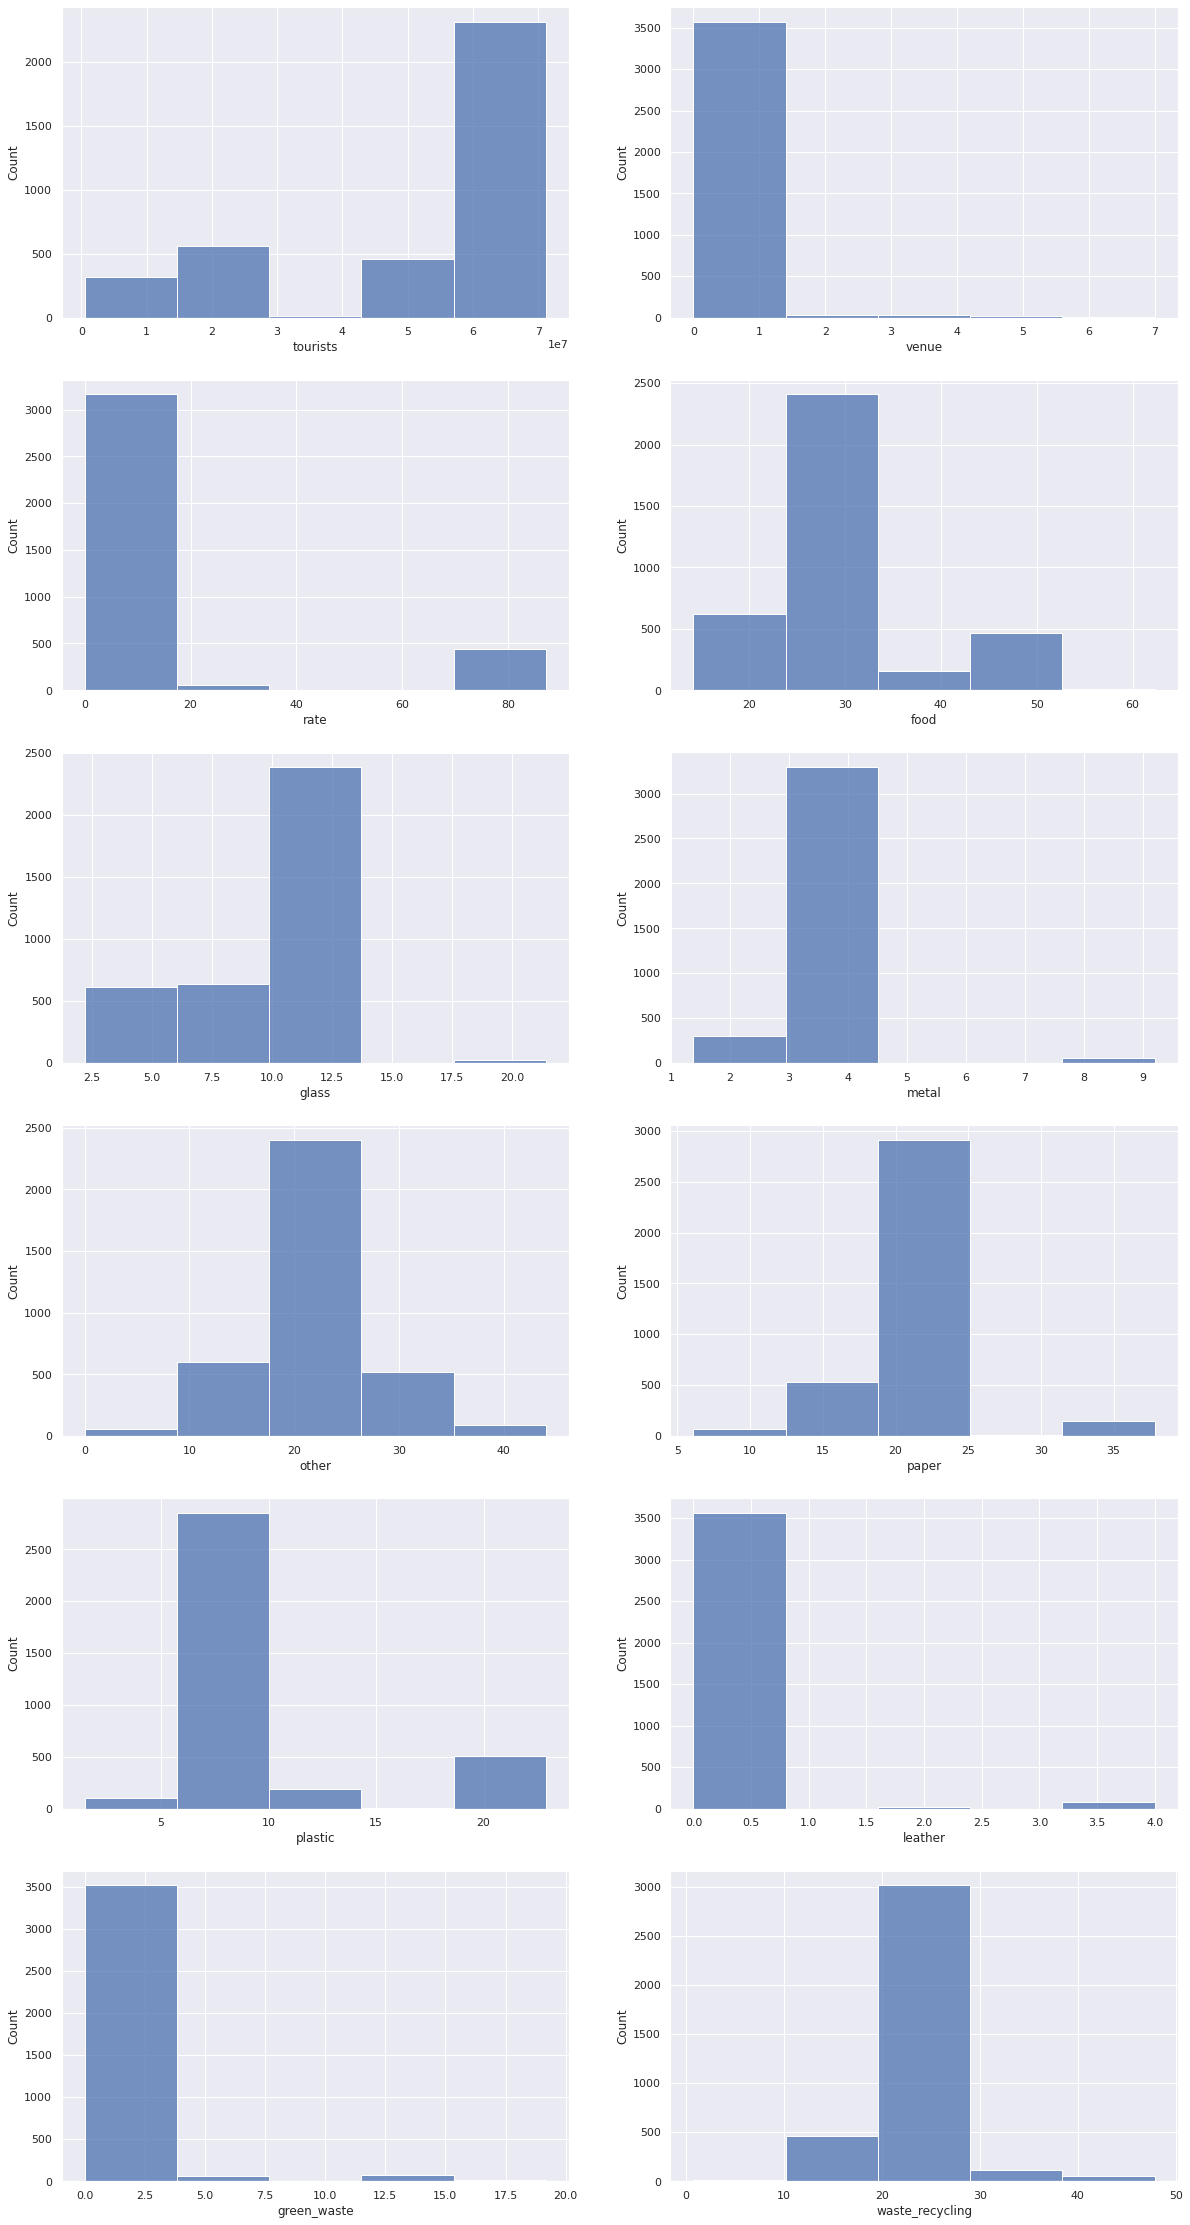

In [ ]:
width = 2 #построим гистограммы данных
height = int(np.ceil(len(num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(20,40))

for idx, column_name in enumerate(num_columns):
    plt.subplot(height,width, idx+1)

    sns.histplot(data=DF_combined, x=column_name, bins = 5);

##3. Проведем манипуляции с данными

Судя по гистораммам начальных данных можно опредилиться с типом преобразования для каждой фичи:

In [ ]:
columns_to_log = ['tourists', 'venue', 'rate', 'glass', 'metal', 'leather', 'green_waste'] #эти признаки приведем к виду номрального распределения
columns_to_norm = list(set(num_columns) - set(columns_to_log)) #для всех остальных из числовых признаков проведем логарифмическое преобразование

Сначала сделаем преобразование к нормальному распределению

In [ ]:
DF_combined_mod = DF_combined[cat_columns] #созадим основу из категориальных признаков

In [ ]:
normal = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0) #определим способ трансформации

In [ ]:
def transrom_to_normal_dist(input_df_name, output_df_name, trasformation_type): #функция для преобразования

  for column in input_df_name[columns_to_norm]:
    array = (input_df_name[column].values).reshape(-1, 1)
    normal_data = trasformation_type.fit_transform(array)
    output_df_name[column] = normal_data

  return output_df_name

In [ ]:
transrom_to_normal_dist(DF_combined, DF_combined_mod, normal) #выполним функцию для преобразования

<ipython-input-19-680fc90b64ea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df_name[column] = normal_data
<ipython-input-19-680fc90b64ea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df_name[column] = normal_data
<ipython-input-19-680fc90b64ea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,code,year,period,id,Country,paper,food,waste_recycling,other,plastic
11,EEA_3161-03-3,2009,2009-04--2009-10,FRGR0220,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
20,EEA_3161-05-5,2009,2009-01--2009-12,FRDR179,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
27,EEA_3161-01-1,2009,2009-01--2009-12,FRDR174,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
28,EEA_3161-05-5,2009,2009-01--2009-12,FRDR174,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
33,EEA_3161-03-3,2009,2009-01--2009-12,FRGR0173,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
...,...,...,...,...,...,...,...,...,...,...
19780,EEA_31615-01-7,2010,2010-01--2010-12,ES020MSPF000000395,Spain,-1.346386,1.529558,-1.497997,-1.231280,-0.180377
19824,EEA_3161-02-2,2009,2009-01--2009-12,FRFR289B,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
19856,EEA_3161-01-1,2009,2009-01--2009-12,FRDR2007E,France,0.311059,0.022584,-0.108103,0.042668,-0.180377
19882,EEA_31615-01-7,2009,2009-01--2009-12,UKSC006828,United Kingdom,-0.728240,-1.368450,1.081940,1.318946,1.475269


Сдеалем логарифимическое преобразование. Чтобы учесть случаи, когда значения = 0 применим преобразование обратного гиперболического синуса:

In [ ]:
DF_combined_mod[columns_to_log] = np.log(DF_combined[columns_to_log] + np.sqrt(DF_combined[columns_to_log] ** 2 + 1))

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Нормализуем получившиеся данные:

In [ ]:
Xmin = DF_combined_mod[num_columns].min()
Xmax = DF_combined_mod[num_columns].max()

DF_combined_mod[num_columns] = (DF_combined_mod[num_columns] - Xmin)/(Xmax - Xmin)
DF_combined_mod.head()

,code,year,period,id,Country,paper,food,waste_recycling,other,plastic,tourists,venue,rate,glass,metal,leather,green_waste
11,EEA_3161-03-3,2009,2009-04--2009-10,FRGR0220,France,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.000000,0.0,0.65931,0.386891,0.0,0.0
20,EEA_3161-05-5,2009,2009-01--2009-12,FRDR179,France,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,0.0,0.0
27,EEA_3161-01-1,2009,2009-01--2009-12,FRDR174,France,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,0.0,0.0
28,EEA_3161-05-5,2009,2009-01--2009-12,FRDR174,France,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,0.0,0.0
33,EEA_3161-03-3,2009,2009-01--2009-12,FRGR0173,France,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.000000,0.0,0.65931,0.386891,0.0,0.0


Построим гистораммы получившихся данных

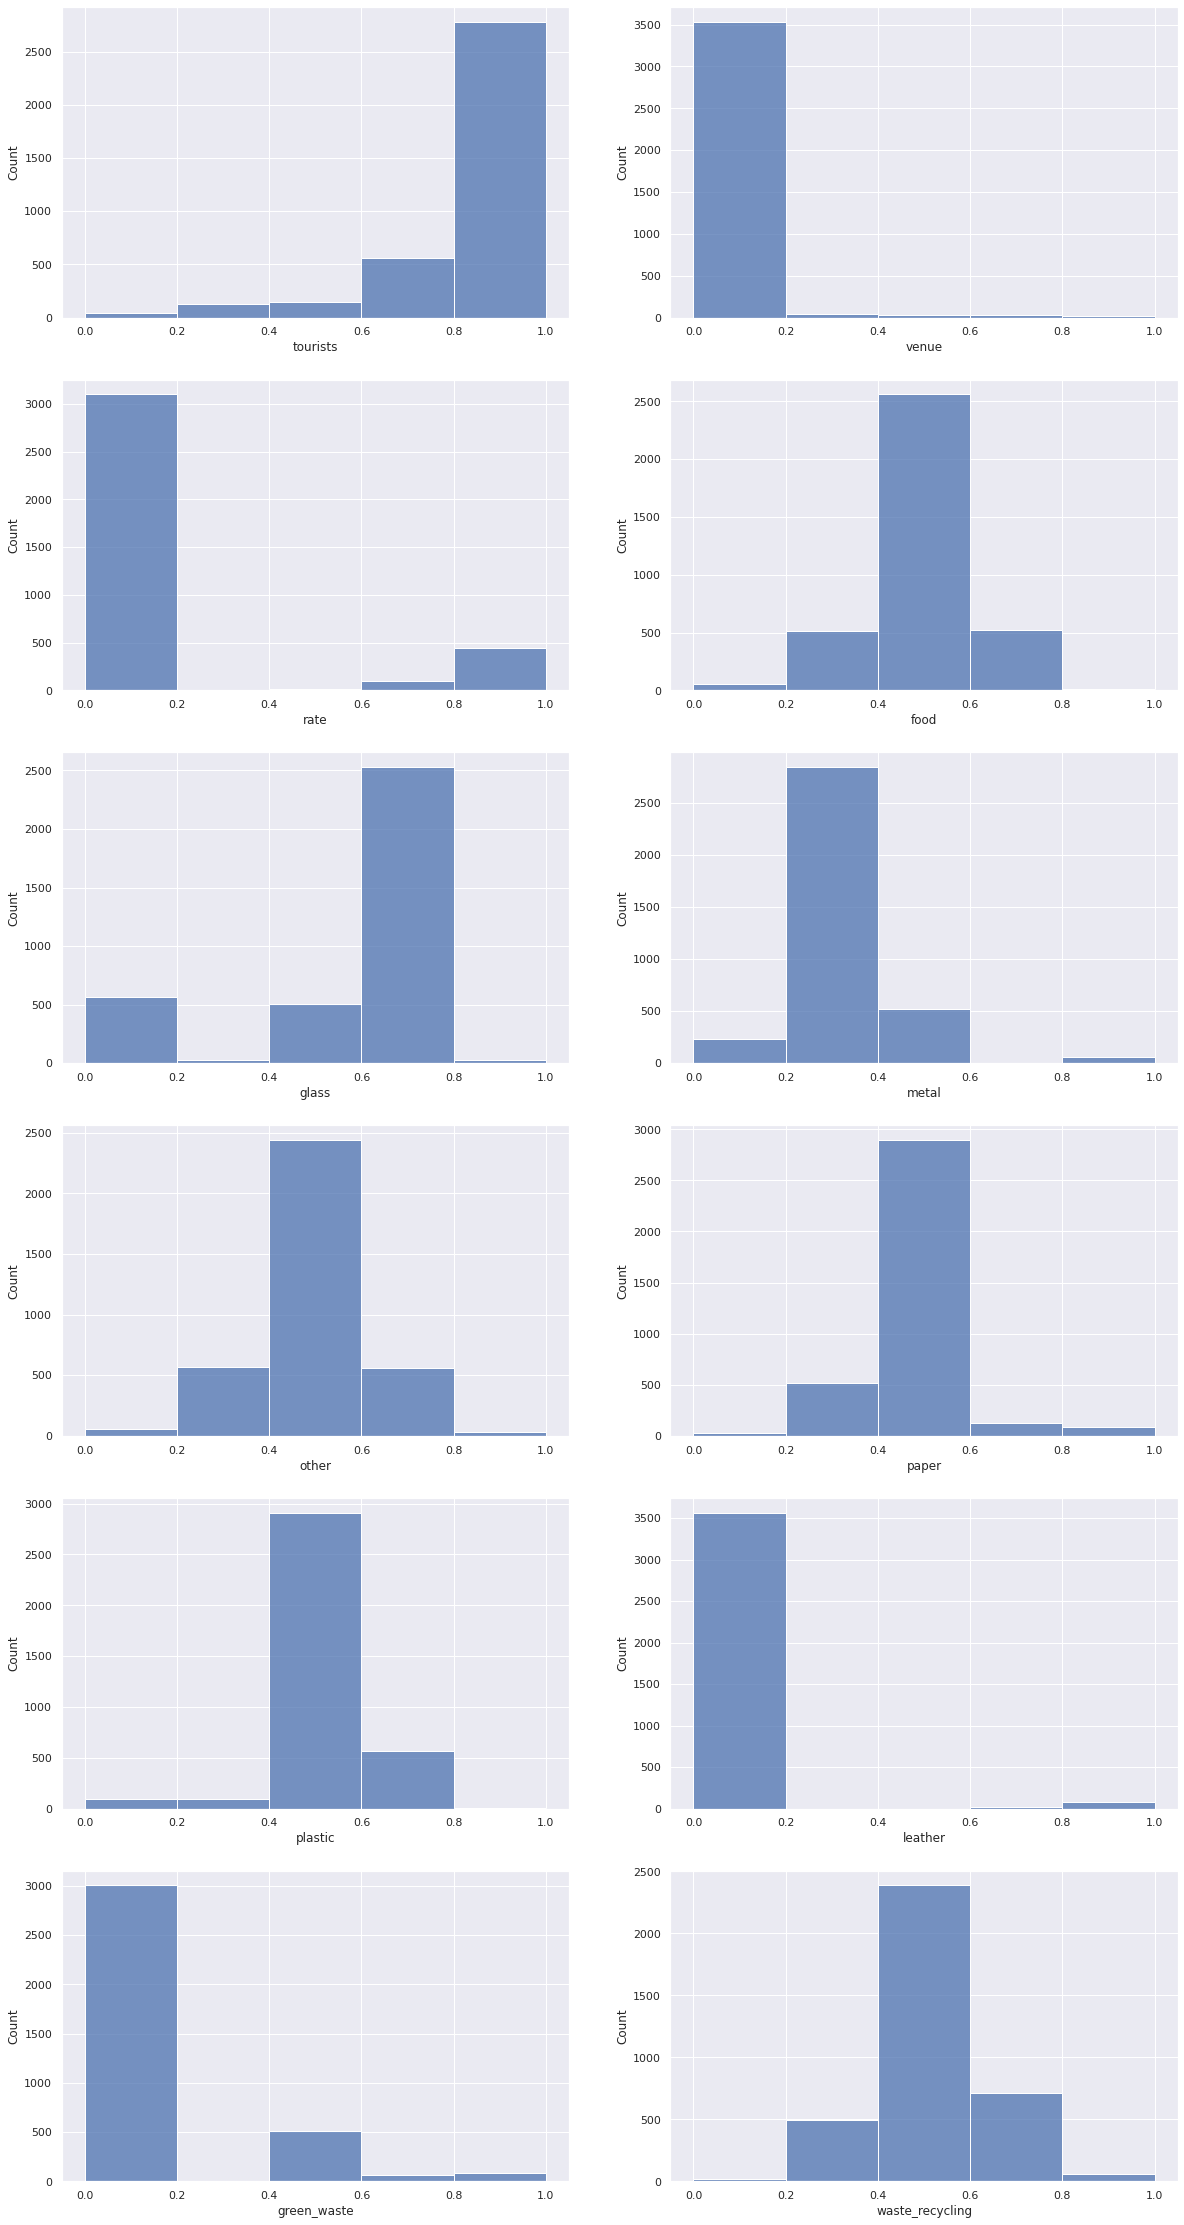

In [ ]:
width = 2
height = int(np.ceil(len(num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(20,40))

for idx, column_name in enumerate(num_columns):
    plt.subplot(height,width, idx+1)

    sns.histplot(data=DF_combined_mod, x=column_name, bins = 5);

Выполним one-hot encoding

In [ ]:
DF_use = pd.get_dummies(DF_combined_mod, columns=cat_columns)
DF_use.head()

,paper,food,waste_recycling,other,plastic,tourists,venue,rate,glass,metal,...,Country_Luxembourg,Country_None,Country_Norway,Country_Portugal,Country_Romania,Country_Serbia,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom
11,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.000000,0.0,0.65931,0.386891,...,0,0,0,0,0,0,0,0,0,0
20,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,...,0,0,0,0,0,0,0,0,0,0
27,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,...,0,0,0,0,0,0,0,0,0,0
28,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.687732,0.0,0.65931,0.386891,...,0,0,0,0,0,0,0,0,0,0
33,0.529913,0.502172,0.489604,0.504103,0.482654,1.0,0.000000,0.0,0.65931,0.386891,...,0,0,0,0,0,0,0,0,0,0


##4. Обучение модели

In [ ]:
Train = DF_use.iloc[0:DF_train.shape[0]:] #разделим снова данные на train и test
Test = DF_use.iloc[DF_train.shape[0]::]

X_train, X_test, Y_train, Y_test = train_test_split(Train.values, Target.values.ravel(), test_size = 0.3, random_state = 42) #определим наборы данных для обучения и валидации

Обучим модель

In [ ]:
def weights_vis(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 );

In [ ]:
#@markdown ### Тип Регуляризации
penalty= 'l1' #@param [ "l2" , "l1", "none"]{type:"string"}
#@markdown ### Константа Регуларизации
regularization = 2.96 #@param {type:"slider", min:0.01, max:3, step:0.05}



LogReg = LogisticRegression(fit_intercept=True,
                            penalty=penalty,solver='saga',
                            C=regularization,
                            max_iter=100000)

LogReg.fit(X_train, Y_train)

B0=LogReg.intercept_[0]
B=LogReg.coef_[0]

features_names=DF_use[num_columns].columns
sign=['+','-']
line='{:.2f}'.format(B0)
for p,(fn,b) in enumerate(zip(features_names,B)):
  if np.abs(b)>0:
    line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

print('Решение')
print(line)

# weights_vis(B, B0, features_names)

Решение
-4.10+9.87*glass+0.26*other-0.38*plastic+2.49*green_waste


Проведем кросс-валидацию:

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(LogReg, X_train, Y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_logreg = pd.DataFrame(scores)
display(DF_cv_logreg)
print('\n')
print(DF_cv_logreg.mean()[2:])

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,35.146235,0.007085,0.770732,0.785388,0.751092,0.822967
1,135.745778,0.006754,0.785366,0.811966,0.733591,0.909091
2,110.225010,0.005751,0.795122,0.808219,0.772926,0.846890
3,114.225910,0.009993,0.800000,0.818584,0.761317,0.885167
4,139.167146,0.006373,0.804401,0.822222,0.764463,0.889423




test_ACC          0.791124
test_F1           0.809276
test_Precision    0.756678
test_Recall       0.870708
dtype: float64


Получим полный отчет:

In [ ]:
Y_predict=LogReg.predict(X_test)
print (classification_report(Y_test, Y_predict, target_names=['Manual','Automatic']))

              precision    recall  f1-score   support

      Manual       0.88      0.75      0.81       444
   Automatic       0.78      0.90      0.83       435

    accuracy                           0.82       879
   macro avg       0.83      0.82      0.82       879
weighted avg       0.83      0.82      0.82       879



Применим модель к изначальным тестовым данным:

In [ ]:
Y_predict=LogReg.predict(Test)
Y_predict

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,

In [ ]:
Submission.polution_clf = Y_predict #сохраним данные
Submission.to_csv('Submission.csv', index=True)